In [30]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from pathlib import Path

In [32]:

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

print(tf.__version__)
# Line 6 activates code execution via graphics card. If no GPU is available, the CPU will be used
tf.config.list_physical_devices('GPU')
# Number of available GPU's on your device
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.6.0
Num GPUs Available:  1


In [24]:
# preset paths
# relative path is the project path, regardless of directory position
relative_project_path = str(Path.cwd())
path_pizza = relative_project_path + "\\foods\pizza"
path_non_pizza = relative_project_path + "\\foods\\non_pizza"
#print(relative_project_path)
#print(path_pizza)
#print(path_non_pizza)

# image attributes
batch_size = 32
img_height = 220
img_width = 220
# train and validation seperate datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(relative_project_path,validation_split=0.2,subset="training",seed=524,image_size=(img_height, img_width),batch_size=batch_size)
validation_dataset = tf.keras.utils.image_dataset_from_directory(relative_project_path,validation_split=0.2,subset="validation",seed=524,image_size=(img_height, img_width),batch_size=batch_size)

class_names = train_dataset.class_names

Found 3603 files belonging to 6 classes.
Using 2883 files for training.
Found 3603 files belonging to 6 classes.
Using 720 files for validation.


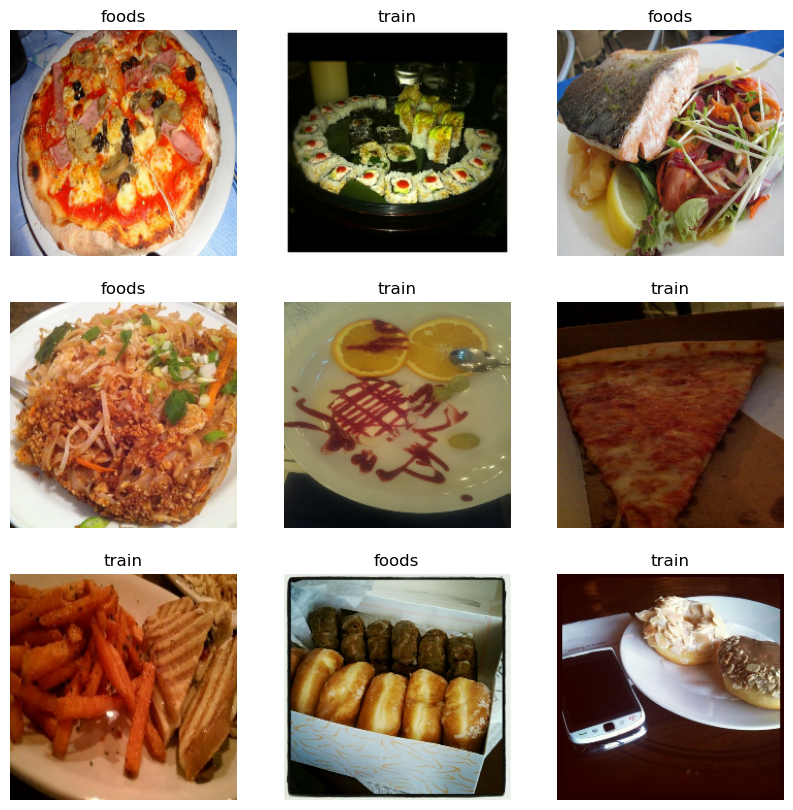

In [25]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

View the pictures

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)

AttributeError: module 'tensorflow.keras.layers' has no attribute 'Rescaling'

In [7]:
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.000116716714 1.0


In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 220, 220, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 64)        1

In [17]:
epochs=100
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/100
40/40 [==============================] - 9s 225ms/step - loss: 0.0738 - accuracy: 0.9742 - val_loss: 1.1082 - val_accuracy: 0.6781
Epoch 2/100
40/40 [==============================] - 9s 219ms/step - loss: 0.0270 - accuracy: 0.9961 - val_loss: 1.3185 - val_accuracy: 0.7156
Epoch 3/100
40/40 [==============================] - 9s 213ms/step - loss: 0.0279 - accuracy: 0.9922 - val_loss: 1.8253 - val_accuracy: 0.6687
Epoch 4/100
40/40 [==============================] - 9s 215ms/step - loss: 0.0233 - accuracy: 0.9930 - val_loss: 1.8964 - val_accuracy: 0.6594
Epoch 5/100
40/40 [==============================] - 10s 238ms/step - loss: 0.0125 - accuracy: 0.9992 - val_loss: 1.8396 - val_accuracy: 0.6375
Epoch 6/100
40/40 [==============================] - 9s 215ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.7345 - val_accuracy: 0.7063
Epoch 7/100
40/40 [==============================] - 9s 215ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 1.7624 - val_accuracy: 0.715

View train results

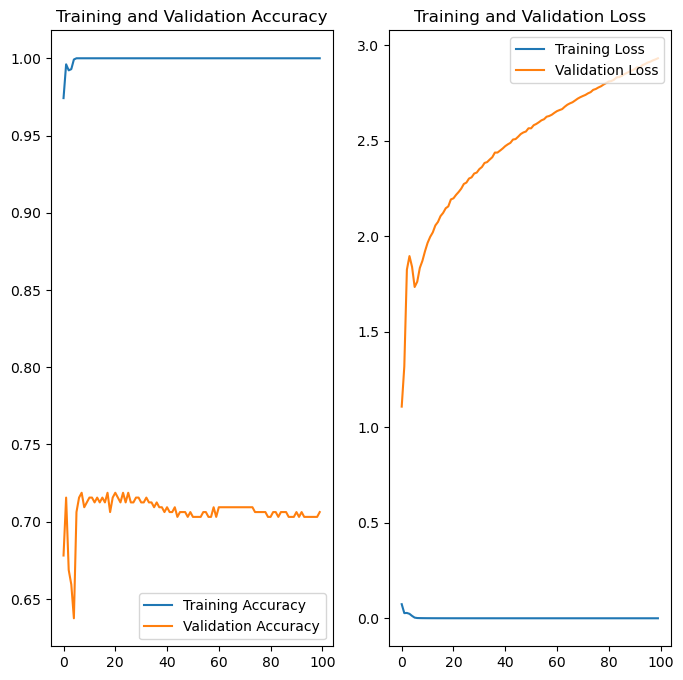

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(train_dataset)

40/40 [==============================] - 2s 49ms/step


In [20]:
# try the trustness of the model
np.argmax(predictions[67])

0

In [21]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

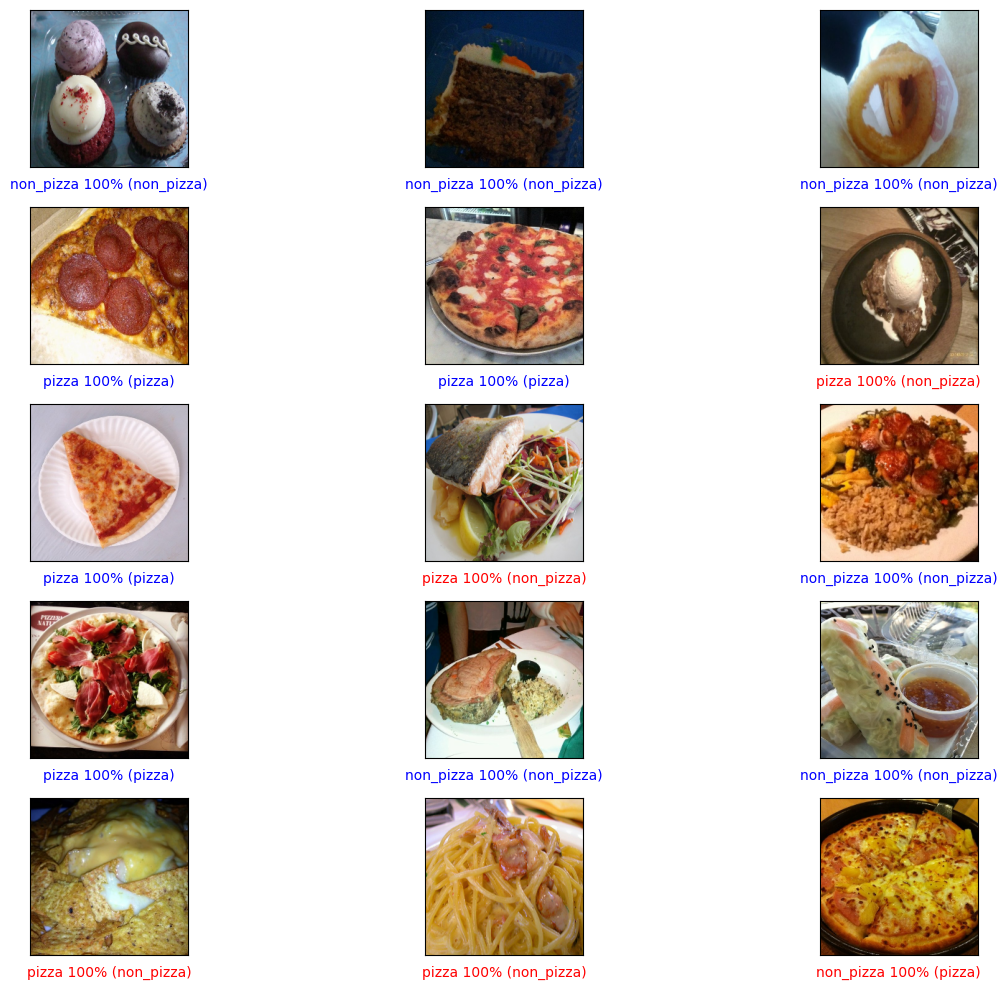

In [22]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], labels_batch, image_batch)
plt.tight_layout()
plt.show()

In [23]:
print('Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!')




Very low accuracy,I guess the reason is that there are only two class called "pizza" and "non pizza".And there are too many possibilities in "non pizza" class!!!
